# Create a NetworkX street network from OpenStreetMap

- https://graph-tool.skewed.de/static/doc/centrality.html

In [1]:
import osmnx, networkx as nx, matplotlib.pyplot as plt, pandas as pd
%matplotlib inline

In [2]:
osmnx.init(file_log=True)

## There are several different ways to construct the network

 #### 1. Pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

In [3]:
# San Francisco
north = 37.81
south = 37.76
east = -122.40
west = -122.45

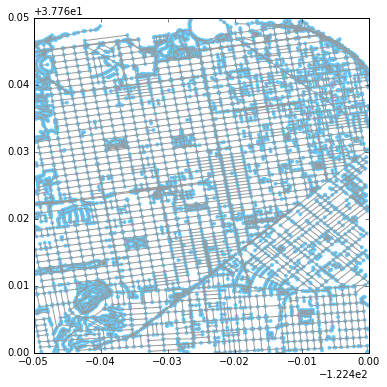

In [4]:
# graph from a bounding box
G1 = osmnx.graph_from_bbox(north, south, east, west)
fig, ax = osmnx.plot_graph(G1)

#### 2. Pass a lat-long point and bounding box distance in meters#### 
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

In [5]:
# Mark Hopkins Hotel in SF
location_point = (37.791427, -122.410018)

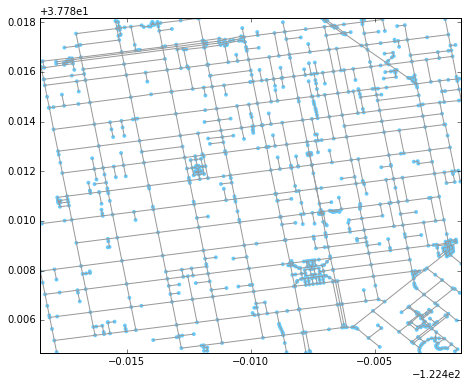

In [6]:
# from some point, with bounding box of N, S, E, W each 0.75 km from point
G2 = osmnx.graph_from_point(location_point, distance=750, distance_type='bbox')
fig, ax = osmnx.plot_graph(G2)

#### 3. Pass a (lat,lon) point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it prunes the network by removing all nodes further than *n* meters from the point along the network.

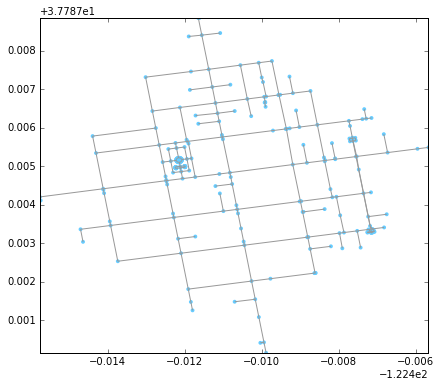

In [7]:
# same point, but create graph only of nodes within 500m along the network from the point
G3 = osmnx.graph_from_point(location_point, distance=500, distance_type='network')
fig, ax = osmnx.plot_graph(G3)

#### 4. Pass an address and distance (bounding box or network) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance (if using network distance).

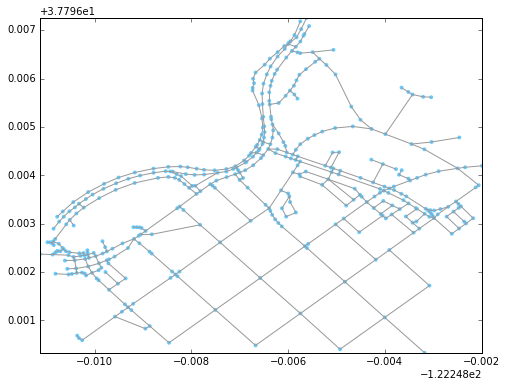

In [8]:
# graph from address, including only nodes within 500m along the network from the address
G4 = osmnx.graph_from_address(address='1611 2nd Ave, Oakland, CA 94606', 
                              distance=500, 
                              distance_type='network')
fig, ax = osmnx.plot_graph(G4)

####  5. Pass a place name ####

In [9]:
G5 = osmnx.graph_from_place('Hong Kong Island', which_result=2)

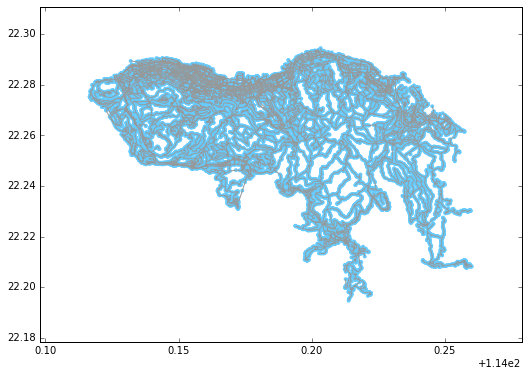

In [10]:
# project the graph to UTM (zone calculated automatically) and plot it
G5_proj = osmnx.project_graph(G5)
fig, ax = osmnx.plot_graph(G5_proj, show=False)
ax.autoscale()
ax.margins(0.1)
plt.show()

## Calculate the network path from the centermost node to some other node

In [25]:
# Mark Hopkins Hotel in SF
location_point = (37.791427, -122.410018)
G = osmnx.graph_from_point(location_point, distance=500, distance_type='network')

In [26]:
# let the origin node be the node nearest the location
origin_node = osmnx.get_nearest_node(G, location_point)

# let the destination node be the last node in the graph
destination_node = G.nodes()[-1]

In [27]:
# find the shortest path between origin and destination
# use weight='length' to find the shortest spatial path, otherwise it treats each edge as weight=1
route = nx.shortest_path(G, origin_node, destination_node)
str(route)

'[373, 402, 600, 570, 133, 343, 622]'

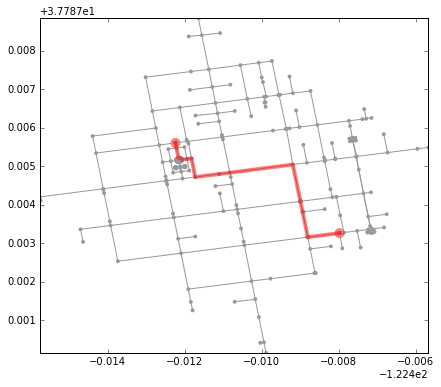

In [33]:
# plot the route
fig, ax = osmnx.plot_graph_route(G, route)

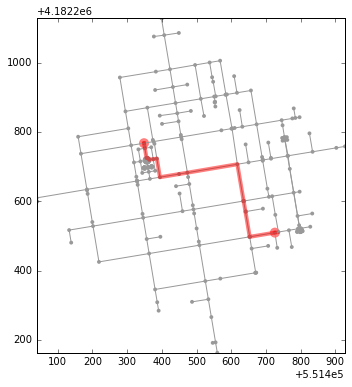

In [34]:
# project the graph to UTM then plot the route
G_proj = osmnx.project_graph(G)
fig, ax = osmnx.plot_graph_route(G_proj, route, x='x', y='y')

## Plot network path from one lat-long to another

In [29]:
origin_point = (37.792896, -122.412325)
origin_node = osmnx.get_nearest_node(G, origin_point)
destination_point = (37.790495, -122.408353)
destination_node = osmnx.get_nearest_node(G, destination_point)
origin_node, destination_node

(319, 286)

In [30]:
# find the shortest path between origin and destination
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[319, 419, 438, 452, 362, 459, 451, 588, 450, 430, 161, 384, 605, 233, 600, 570, 336, 334, 35, 67, 286]'

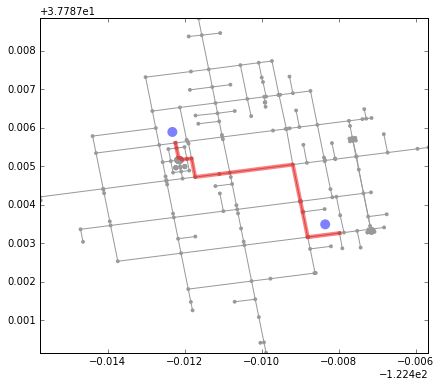

In [32]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = osmnx.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## Define functions to get colors for different node and edge types

In [19]:
pd.Series([node['highway'] for node in G5.node.values()]).value_counts()

                     40236
crossing               670
turning_circle          59
motorway_junction       36
traffic_signals         32
mini_roundabout         25
elevator                23
turning_loop             1
give_way                 1
stop                     1
dtype: int64

In [20]:
list(G5.edges(data=True))[100]

(58,
 38350,
 {'city': '',
  'highway': '',
  'length': 63.5956611763409,
  'maxspeed': '',
  'name': '',
  'osmid': 293838960})

In [21]:
pd.Series([edge['highway'] for _, _, edge in G5.edges(data=True)]).value_counts()

    44257
dtype: int64

In [22]:
def get_node_color(node):
    hwy = node['highway']
    if hwy is None:
        return 'b'
    elif hwy == 'crossing':
        return 'r'
    elif hwy == 'stop':
        return 'g'
    elif hwy == 'traffic_signals':
        return 'c'
    else:
        return 'k'

In [23]:
def get_edge_color(edge_details):
    hwy = edge_details['highway']
    if hwy in ['primary', 'secondary', 'tertiary', 'residential']:
        return 'b'
    elif hwy in ['footway', 'steps', 'path', 'pedestrian', 'track', 'cycleway']:
        return 'g'
    elif hwy in ['primary_link', 'secondary_link', 'tertiary_link']:
        return 'b'
    elif hwy in ['service']:
        return 'm'
    elif hwy in ['unclassified']:
        return 'b'
    else:
        return 'r'